<a href="https://colab.research.google.com/github/Manolo1109/Proyecto_Fundamentos/blob/Imputaciones/Proyecto_Fundamentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objetivo de negocio**

El objetivo del presente proyecto es ayudar al gerente a predecir el grupo correcto de nuevos
clientes, así como establecer cuál fue la caracterización de los clientes por segmentos.


**Metodología**
1. Limpieza y EDA: compruebe si hay problemas de calidad de datos.
Debe evaluar la calidad de los datos, así como comprender la relación entre las
características y la variable de destino.
2. Modelos predictivos: Entrene modelos predictivos (al menos 3) que te permitirán predecir
el segmento al que pertenecería cada cliente con base en los valores de sus atributos. Elija
el mejor modelo, buscando sus parámetros óptimos. Debe incluir un apartado en el que
establezcas los protocolos de evaluación y los procesos de formación y evaluación de los
modelos.
3. Reducción de dimensionalidad: Considerando todas las variables, realizar un análisis de
componentes principales (PCA), eligiendo el número de componentes necesarios para
conservar al menos el 80% de la representación original.
4. Caracterización de los clientes por segmento: Con los datos en su nueva representación,
realizar una segmentación, estableciendo el mejor número de conglomerados entre 3 y 5.
Caracterizar los conglomerados con respecto a las variables originales.

# **Importando las librerías**

In [88]:
#herramientas
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.preprocessing import StandardScaler
import string
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

#métricas
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, mean_squared_error
from tqdm.auto import tqdm
import time

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate


In [2]:
import warnings
warnings.filterwarnings('ignore')

# **Cargando los Datos**

In [108]:
df_train = pd.read_csv("Train.csv")
df_test = pd.read_csv("Test.csv")

# **Primer vistazo a los datos**

In [66]:
df_train.shape

(8068, 11)

In [67]:
df_train.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [68]:
df_test.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [69]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [70]:
df_train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [71]:
df_train.tail()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
8063,464018,Male,No,22,No,NaN,0.0,Low,7.0,Cat_1,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B
8067,461879,Male,Yes,37,Yes,Executive,0.0,Average,3.0,Cat_4,B


# **Búsqueda de valores nulos y control de calidad de los datos**

In [13]:
df_train.isna().any()

ID                 False
Gender             False
Ever_Married        True
Age                False
Graduated           True
Profession          True
Work_Experience     True
Spending_Score     False
Family_Size         True
Var_1               True
Segmentation       False
dtype: bool

In [14]:
df_train.isna().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [42]:
df_train = df_train.drop('ID', axis=1)
df_test = df_test.drop('ID', axis=1)

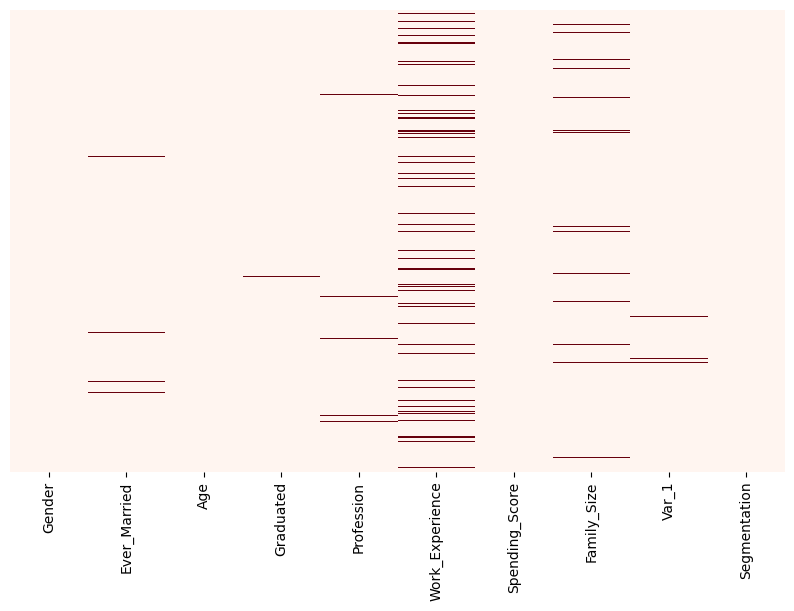

In [62]:
plt.figure(figsize=(10,6))
sns.heatmap(df_train.isnull(), yticklabels = False, cbar = False, cmap="Reds")
plt.show()

# **One Hot Encoding**

In [109]:
df_train = pd.get_dummies(df_train,columns=['Gender'])
df_train = pd.get_dummies(df_train,columns=['Ever_Married'])
df_train = pd.get_dummies(df_train,columns=['Graduated'])
df_train = pd.get_dummies(df_train,columns=['Profession'])
df_train = pd.get_dummies(df_train,columns=['Spending_Score'])
df_train = pd.get_dummies(df_train,columns=['Var_1'])
df_train = pd.get_dummies(df_train,columns=['Segmentation'])
df_train

,ID,Age,Work_Experience,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,...,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Segmentation_A,Segmentation_B,Segmentation_C,Segmentation_D
0,462809,22,1.0,4.0,0,1,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,462643,38,NaN,3.0,1,0,0,1,0,1,...,0,0,1,0,0,0,1,0,0,0
2,466315,67,1.0,1.0,1,0,0,1,0,1,...,0,0,0,0,1,0,0,1,0,0
3,461735,67,0.0,2.0,0,1,0,1,0,1,...,0,0,0,0,1,0,0,1,0,0
4,462669,40,NaN,6.0,1,0,0,1,0,1,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,22,0.0,7.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
8064,464685,35,3.0,4.0,0,1,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
8065,465406,33,1.0,1.0,1,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
8066,467299,27,1.0,4.0,1,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0


In [101]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        8068 non-null   int64  
 1   Age                       8068 non-null   int64  
 2   Work_Experience           7239 non-null   float64
 3   Family_Size               7733 non-null   float64
 4   Segmentation              8068 non-null   object 
 5   Gender_Female             8068 non-null   uint8  
 6   Gender_Male               8068 non-null   uint8  
 7   Ever_Married_No           8068 non-null   uint8  
 8   Ever_Married_Yes          8068 non-null   uint8  
 9   Graduated_No              8068 non-null   uint8  
 10  Graduated_Yes             8068 non-null   uint8  
 11  Profession_Artist         8068 non-null   uint8  
 12  Profession_Doctor         8068 non-null   uint8  
 13  Profession_Engineer       8068 non-null   uint8  
 14  Professi

# **Valores únicos del dataset**

In [102]:
df_train.nunique()

ID                          8068
Age                           67
Work_Experience               15
Family_Size                    9
Segmentation                   4
Gender_Female                  2
Gender_Male                    2
Ever_Married_No                2
Ever_Married_Yes               2
Graduated_No                   2
Graduated_Yes                  2
Profession_Artist              2
Profession_Doctor              2
Profession_Engineer            2
Profession_Entertainment       2
Profession_Executive           2
Profession_Healthcare          2
Profession_Homemaker           2
Profession_Lawyer              2
Profession_Marketing           2
Spending_Score_Average         2
Spending_Score_High            2
Spending_Score_Low             2
Var_1_Cat_1                    2
Var_1_Cat_2                    2
Var_1_Cat_3                    2
Var_1_Cat_4                    2
Var_1_Cat_5                    2
Var_1_Cat_6                    2
Var_1_Cat_7                    2
dtype: int

In [93]:
df_test.nunique()

ID                 2627
Gender                2
Ever_Married          2
Age                  67
Graduated             2
Profession            9
Work_Experience      15
Spending_Score        3
Family_Size           9
Var_1                 7
Segmentation          4
dtype: int64

# **Distribución de las clases**

In [104]:
df_train['Segmentation'].value_counts().sort_index()

A    1972
B    1858
C    1970
D    2268
Name: Segmentation, dtype: int64

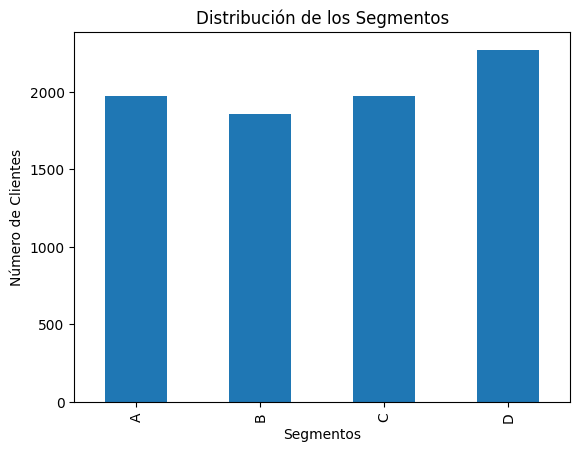

In [77]:
class_counts = df_train['Segmentation'].value_counts().sort_index()
class_counts.plot(kind='bar')
plt.title('Distribución de los Segmentos')
plt.xlabel('Segmentos')
plt.ylabel('Número de Clientes')
plt.show()

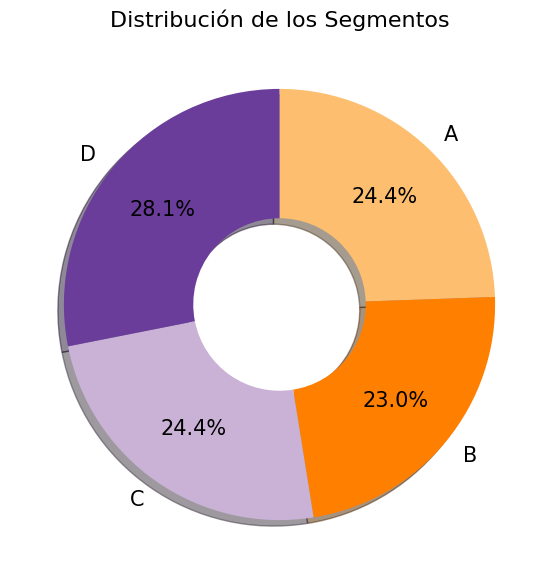

In [78]:
plt.figure(figsize = (7,7))
sorted_counts = df_train['Segmentation'].value_counts().sort_index()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[6:])
plt.title('Distribución de los Segmentos', fontsize = 16);

# **Imputacion de datos faltantes**

In [110]:
def obtain_X_y(df):
    return df.drop(columns=['Segmentation_A']),df[['Segmentation_A']]

In [111]:

def optimize_k(df):
    errors = []
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(df)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)

        X,y = obtain_X_y(df_imputed)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

        model = RandomForestRegressor(random_state=1234)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = np.sqrt(mean_squared_error(y_test, preds))
        errors.append({'K': k, 'RMSE': error, 'R^2': r2_score(y_test,preds)})

    return errors

errors = optimize_k(df_train)
print(errors)

[{'K': 1, 'RMSE': 0.0, 'R^2': 1.0}, {'K': 3, 'RMSE': 0.0, 'R^2': 1.0}, {'K': 5, 'RMSE': 0.0, 'R^2': 1.0}, {'K': 7, 'RMSE': 0.0, 'R^2': 1.0}, {'K': 9, 'RMSE': 0.0, 'R^2': 1.0}, {'K': 11, 'RMSE': 0.0, 'R^2': 1.0}, {'K': 13, 'RMSE': 0.0, 'R^2': 1.0}, {'K': 15, 'RMSE': 0.0, 'R^2': 1.0}, {'K': 17, 'RMSE': 0.0, 'R^2': 1.0}, {'K': 19, 'RMSE': 0.0, 'R^2': 1.0}]


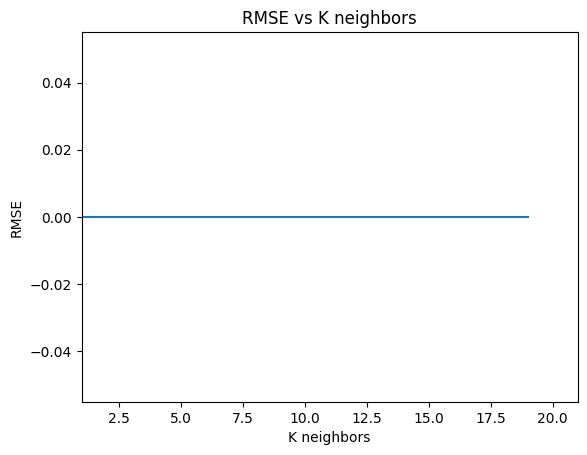

In [112]:
ax = sns.lineplot(x=[errors[i]['K'] for i in range(len(errors))],y=[errors[i]['RMSE'] for i in range(len(errors))])
ax.set(title='RMSE vs K neighbors',xlim=(1,21),xlabel='K neighbors', ylabel='RMSE')
plt.show()

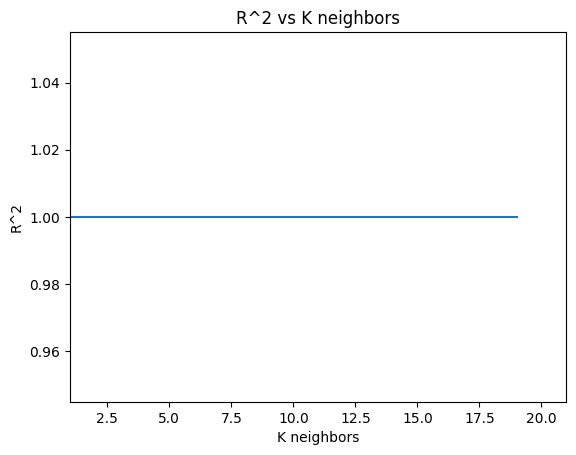

In [113]:
ax = sns.lineplot(x=[errors[i]['K'] for i in range(len(errors))],y=[errors[i]['R^2'] for i in range(len(errors))])
ax.set(title='R^2 vs K neighbors',xlim=(1,21),xlabel='K neighbors', ylabel='R^2')
plt.show()

In [115]:
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(df_train)
df_imputed = pd.DataFrame(imputed, columns=df_train.columns)
X_knn,y_knn = obtain_X_y(df_imputed)

In [117]:
df_train.isna().sum()

ID                            0
Age                           0
Work_Experience             829
Family_Size                 335
Gender_Female                 0
Gender_Male                   0
Ever_Married_No               0
Ever_Married_Yes              0
Graduated_No                  0
Graduated_Yes                 0
Profession_Artist             0
Profession_Doctor             0
Profession_Engineer           0
Profession_Entertainment      0
Profession_Executive          0
Profession_Healthcare         0
Profession_Homemaker          0
Profession_Lawyer             0
Profession_Marketing          0
Spending_Score_Average        0
Spending_Score_High           0
Spending_Score_Low            0
Var_1_Cat_1                   0
Var_1_Cat_2                   0
Var_1_Cat_3                   0
Var_1_Cat_4                   0
Var_1_Cat_5                   0
Var_1_Cat_6                   0
Var_1_Cat_7                   0
Segmentation_A                0
Segmentation_B                0
Segmenta

In [120]:
df_train['Family_Size'].fillna(df_train['Family_Size'].mean(), inplace=True)

In [122]:
df_train['Work_Experience'].fillna(df_train['Work_Experience'].mean(), inplace=True)

In [123]:
df_train.isna().sum()


ID                          0
Age                         0
Work_Experience             0
Family_Size                 0
Gender_Female               0
Gender_Male                 0
Ever_Married_No             0
Ever_Married_Yes            0
Graduated_No                0
Graduated_Yes               0
Profession_Artist           0
Profession_Doctor           0
Profession_Engineer         0
Profession_Entertainment    0
Profession_Executive        0
Profession_Healthcare       0
Profession_Homemaker        0
Profession_Lawyer           0
Profession_Marketing        0
Spending_Score_Average      0
Spending_Score_High         0
Spending_Score_Low          0
Var_1_Cat_1                 0
Var_1_Cat_2                 0
Var_1_Cat_3                 0
Var_1_Cat_4                 0
Var_1_Cat_5                 0
Var_1_Cat_6                 0
Var_1_Cat_7                 0
Segmentation_A              0
Segmentation_B              0
Segmentation_C              0
Segmentation_D              0
dtype: int

# **Partición de los datos**

In [125]:
X_train, X_test, y_train, y_test = train_test_split(
                                                df_train.drop('Segmentation_A', axis=1),
                                                df_train['Segmentation_A'],
                                                test_size=0.2,
                                                random_state=42)

# **Módelos de clasificación**

# **1. Logistic Regression**

In [126]:
# Crear
clf_lr = LogisticRegression(multi_class='multinomial')

In [127]:
# Entrenar
clf_lr.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [128]:
# Predecir
y_pred_lr = clf_lr.predict(X_test)
y_pred_lr

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [129]:
# Reporte
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1223
           1       0.00      0.00      0.00       391

    accuracy                           0.76      1614
   macro avg       0.38      0.50      0.43      1614
weighted avg       0.57      0.76      0.65      1614



<Axes: >

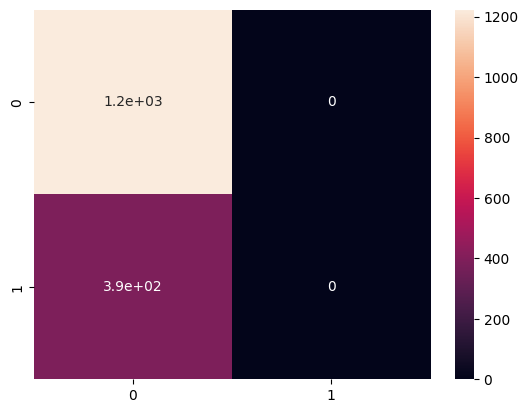

In [130]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True)

# **1. Logistic Regression: Tuning**

In [ ]:
parameters = {
    'multi_class' : ['multinomial'],
    'penalty' : ['l1','l2'],
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [ ]:
log_reg = LogisticRegression()
log_reg_gs = GridSearchCV(log_reg,
                   param_grid = parameters,
                   scoring='accuracy',
                   cv=7)

In [ ]:
log_reg_gs.fit(X_train,y_train)

GridSearchCV(cv=7, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'multi_class': ['multinomial'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [ ]:
log_reg_gs.best_score_

0.8017456414384511

In [ ]:
log_reg_gs.best_estimator_.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

# **2. Naive Bayes**

In [54]:
# Crear
clf_nb = MultinomialNB()

In [55]:
# Entrenar
clf_nb.fit(X_train, y_train)

ValueError: ignored

In [ ]:
# Predecir
y_pred_nb = clf_nb.predict(X_test)
y_pred_nb

array([1, 2, 1, ..., 0, 0, 0], dtype=int8)

In [ ]:
# Reporte
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.69      0.98      0.81      1603
           1       0.83      0.88      0.85      1603
           2       0.75      0.83      0.79      1531
           3       0.66      0.34      0.45      1624
           4       0.60      0.39      0.47      1612
           5       0.77      0.97      0.86      1566

    accuracy                           0.73      9539
   macro avg       0.72      0.73      0.71      9539
weighted avg       0.72      0.73      0.70      9539



<Axes: >

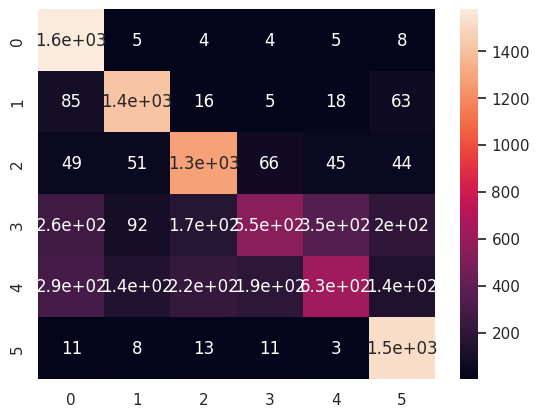

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot=True)

# **2. Naive Bayes: Tuning**

In [ ]:
parameters = {'alpha': [0.01, 0.001, 0.1, 0.5, 1.0, 10.0],
              'fit_prior': [True, False]
              }

In [ ]:
multi_nb = MultinomialNB()
multi_nb_gs = GridSearchCV(multi_nb,
                   param_grid = parameters,
                   scoring='accuracy',
                   cv=7)

In [ ]:
multi_nb_gs.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.001, 0.1, 0.5, 1.0, 10.0],
                         'fit_prior': [True, False]},
             scoring='accuracy')

In [ ]:
multi_nb_gs.best_score_

0.7442925210255167

In [ ]:
multi_nb_gs.best_estimator_.get_params()

{'alpha': 0.5, 'class_prior': None, 'fit_prior': False, 'force_alpha': 'warn'}

# **3. Random Forest**

In [56]:
# Crear
clf_rf = RandomForestClassifier()

In [98]:
# Entrenar
clf_rf.fit(X_train, y_train)

ValueError: ignored

In [ ]:
# Predecir
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf

array([1, 2, 1, ..., 0, 1, 4], dtype=int8)

In [ ]:
# Reporte
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1603
           1       0.98      0.97      0.98      1603
           2       0.88      0.81      0.85      1531
           3       0.53      0.48      0.51      1624
           4       0.53      0.62      0.57      1612
           5       0.95      0.94      0.95      1566

    accuracy                           0.80      9539
   macro avg       0.81      0.80      0.80      9539
weighted avg       0.80      0.80      0.80      9539



<Axes: >

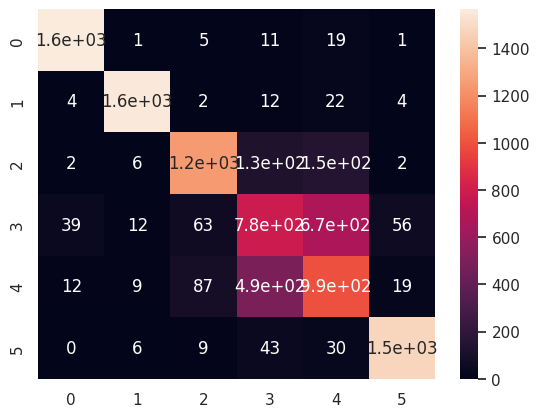

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True)

# **3. Random Forest: Tuning**

In [ ]:
parameters = {
    'n_estimators': [100, 120, 140, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [20, 25, 30],
    'max_leaf_nodes': [20, 25, 30],
}

In [ ]:
random_forest = RandomForestClassifier()
random_forest_gs = GridSearchCV(random_forest,
                   param_grid = parameters,
                   scoring='accuracy',
                   cv=7)

In [ ]:
random_forest_gs.fit(X_train, y_train)

In [ ]:
random_forest_gs.best_score_

In [ ]:
random_forest_gs.best_estimator_.get_params()

# **4. KNN**

In [58]:
# Crear
clf_knn = KNeighborsClassifier(n_neighbors=5)

In [59]:
# Entrenar
clf_knn.fit(X_train, y_train)

ValueError: ignored

In [ ]:
# Predecir
y_pred_knn = clf_knn.predict(X_test)
y_pred_knn

array(['other_cyberbullying', 'not_cyberbullying', 'other_cyberbullying',
       ..., 'other_cyberbullying', 'other_cyberbullying',
       'other_cyberbullying'], dtype=object)

In [ ]:
# Reporte
print(classification_report(y_test, y_pred_knn))

                     precision    recall  f1-score   support

                age       0.97      0.07      0.13      1603
          ethnicity       0.99      0.21      0.35      1603
             gender       0.90      0.11      0.20      1531
  not_cyberbullying       0.23      0.13      0.16      1624
other_cyberbullying       0.16      0.79      0.27      1612
           religion       0.97      0.02      0.05      1566

           accuracy                           0.23      9539
          macro avg       0.70      0.22      0.19      9539
       weighted avg       0.70      0.23      0.19      9539



# **4. KNN: Tuning**

In [ ]:
leaf_size = list(range(1,15))
n_neighbors = list(range(1,15))
p=[1,2]
parameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

In [ ]:
knn = KNeighborsClassifier()
knn_gs = GridSearchCV(knn,
                   param_grid = parameters,
                   scoring='accuracy',
                   cv=7)

In [ ]:
knn_gs.fit(X_train, y_train)

In [ ]:
knn_gs.best_score_

In [ ]:
knn_gs.best_estimator_.get_params()

# **Validación Cruzada cv-7**

In [ ]:
def cross_validation(model, X, y, cv=7):
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=X,
                               y=y,
                               cv=cv,
                               scoring=_scoring,
                               return_train_score=True)

      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              }

In [ ]:
models = {
    "Regresion Logistica" : LogisticRegression(multi_class='multinomial'),
    "Naive Bayes" : MultinomialNB(),
    "Random Forest" : RandomForestClassifier(),
    "KNN" : KNeighborsClassifier(n_neighbors=5)
}

In [ ]:
for i in models.keys():
  print('---------- ' + i + ' ----------')
  cross_v = cross_validation(models[i], X_tf, df['cyberbullying_type'])
  for j in cross_v.keys():
    print(f'{j} : {cross_v[j]}')
  print('--------------------')

---------- Regresion Logistica ----------
Training Accuracy scores : [0.89515143 0.89635265 0.89657281 0.89667066 0.89649943 0.89696421
 0.89769808]
Mean Training Accuracy : 89.65584675031405
Validation Accuracy scores : [0.80275903 0.80023485 0.79524439 0.80463819 0.79994129 0.80874798
 0.79935418]
Mean Validation Accuracy : 80.15599849232447
--------------------
---------- Naive Bayes ----------
Training Accuracy scores : [0.83668477 0.83712909 0.83683554 0.83788742 0.8364686  0.83739818
 0.83583258]
Mean Training Accuracy : 83.68908824466956
Validation Accuracy scores : [0.74024068 0.73800088 0.7344782  0.73095553 0.74137678 0.73726699
 0.73873477]
Mean Validation Accuracy : 73.72934046113325
--------------------
---------- Random Forest ----------
Training Accuracy scores : [0.96641225 0.96678001 0.96636415 0.96731818 0.96594829 0.96670662
 0.96663323]
Mean Training Accuracy : 96.65946763173936
Validation Accuracy scores : [0.80011741 0.80008807 0.80023485 0.80067518 0.79862028 0.7